# 1. 나만의 Mnist CNN

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist

(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
X_train_full = X_train_full.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
print(X_train.shape)
print(X_valid.shape)

(45000, 28, 28, 1)
(15000, 28, 28, 1)


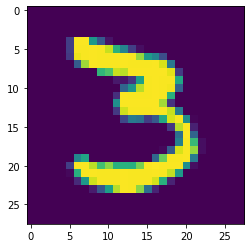

In [4]:
plt.imshow(X_valid[0])

In [11]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [12]:
train_set = train_set.shuffle(10000).batch(100).prefetch(1)
test_set = test_set.batch(100).prefetch(1)
valid_set = valid_set.batch(100).prefetch(1)

In [13]:
my_cnn = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, strides=1, input_shape=[28,28,1], padding="same", activation="elu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", strides=1, padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", strides=1, padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", strides=1, padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", strides=1, padding="same"),
    keras.layers.Dropout(0.4),
    keras.layers.MaxPooling2D(2),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
my_cnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
my_cnn.fit(train_set, epochs=25, validation_data=valid_set)

Epoch 1/25
450/450 [==============================] - 7s 15ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.0390 - val_accuracy: 0.9913
Epoch 2/25
 45/450 [==>...........................] - ETA: 5s - loss: 0.0049 - accuracy: 0.9987

KeyboardInterrupt: 

In [17]:
my_cnn.evaluate(test_set)

100/100 [==============================] - 1s 7ms/step - loss: 0.0266 - accuracy: 0.9932


[0.026568768545985222, 0.9932000041007996]

 # 10. 전이 학습을 사용한 대규모 이미지 분류

In [18]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("rock_paper_scissors", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

2022-07-08 11:28:34.991416: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /home/dongho/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteN9GW9Z/rock_paper_scissors-trai…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /home/dongho/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteN9GW9Z/rock_paper_scissors-test…

Dataset rock_paper_scissors downloaded and prepared to /home/dongho/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [21]:

print(dataset_size)
print(class_names)
print(n_classes)
test_size = info.splits["test"].num_examples
print(test_size)

2520
['rock', 'paper', 'scissors']
3
372


In [39]:
train_set_raw = dataset["train"]
test_set_raw = dataset["test"]

In [44]:
from functools import partial
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat() # an infinite dataset!
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1) # use partial to put in values for a function!
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [45]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.4)(avg)
output = keras.layers.Dense(n_classes, activation="softmax")(dropout)

model = keras.Model(inputs=base_model.input, outputs=output)

In [46]:
for layer in base_model.layers:
    layer.trainable=False

In [48]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=20, validation_data=test_set,
                   steps_per_epoch=int(dataset_size / batch_size),
                   validation_steps=int(test_size / batch_size))

Epoch 1/20
78/78 [==============================] - 13s 154ms/step - loss: 0.4389 - accuracy: 0.8349 - val_loss: 0.7922 - val_accuracy: 0.6250
Epoch 2/20
78/78 [==============================] - 12s 148ms/step - loss: 0.1962 - accuracy: 0.9483 - val_loss: 0.9171 - val_accuracy: 0.6392
Epoch 3/20
78/78 [==============================] - 12s 148ms/step - loss: 0.1609 - accuracy: 0.9547 - val_loss: 1.0657 - val_accuracy: 0.6278
Epoch 4/20
78/78 [==============================] - 12s 149ms/step - loss: 0.1484 - accuracy: 0.9607 - val_loss: 1.0357 - val_accuracy: 0.6051
Epoch 5/20
78/78 [==============================] - 12s 149ms/step - loss: 0.1296 - accuracy: 0.9696 - val_loss: 1.0324 - val_accuracy: 0.6222
Epoch 6/20
78/78 [==============================] - 12s 149ms/step - loss: 0.1262 - accuracy: 0.9651 - val_loss: 0.9517 - val_accuracy: 0.6364
Epoch 7/20
78/78 [==============================] - 12s 148ms/step - loss: 0.1259 - accuracy: 0.9663 - val_loss: 0.9229 - val_accuracy: 0.6392

In [50]:
for layer in base_model.layers:
    layer.trainable=True

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=20, validation_data=test_set,
                   steps_per_epoch=int(dataset_size / batch_size),
                   validation_steps=int(test_size / batch_size))

Epoch 1/20
78/78 [==============================] - 46s 565ms/step - loss: 0.0055 - accuracy: 0.9996 - val_loss: 0.3396 - val_accuracy: 0.8750
Epoch 2/20
13/78 [====>.........................] - ETA: 36s - loss: 0.0029 - accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
model.save("rock_paper_scissors_xception.h5")

In [51]:
model.evaluate(test_set)

12/12 [==============================] - 2s 128ms/step - loss: 0.3398 - accuracy: 0.8737


[0.339801549911499, 0.8736559152603149]